_____
***Маркетинг***

_____
**Описание проекта.**

Проект направлен на создание модели машинного обучения для предсказания вероятности покупки пользователем интернет-магазина в течение следующих 90 дней. Интернет-магазин собирает данные о покупках и рассылках, чтобы лучше понимать поведение клиентов и проводить целевые маркетинговые кампании. Оптимизация процесса позволит выделять пользователей с высокой вероятностью покупки, что повысит эффективность рассылок и увеличит продажи.    
_____
**Задачи проекта.**

1. Изучение и анализ предоставленных данных о покупках пользователей и истории рекламных рассылок для выявления ключевых закономерностей и особенностей.
2. Разработка информативных признаков, отражающих поведение пользователей, их взаимодействие с рассылками и покупательскую активность, с целью повышения качества модели.
3. Построение и обучение модели классификации для предсказания вероятности совершения покупки пользователем в течение 90 дней.
4. Оптимизация и улучшение модели с целью максимизации метрики качества roc_auc, включая подбор алгоритмов и настройку гиперпараметров.
_____
**Исходные данные.**

В проекте используются данные интернет-магазина: история покупок пользователей с информацией о товарах, их количестве, цене и категориях; история рассылок с деталями рекламных кампаний, взаимодействиями пользователей и каналами коммуникации; а также целевой признак, показывающий, совершил ли пользователь покупку в течение 90 дней. Эти данные позволяют анализировать поведение клиентов и создавать модель для прогнозирования вероятности покупки.
______
**Этапы проектной работы.**

- [Загрузка данных](#str1): загрузка и проверка данных. 
- [Предобработка данных](#str2): проверка на наличие пропусков и дубликатов, дисбаланса классов. 
- [Исследовательский анализ данных](#str3): анализ всех признаков.
- [Обучение моделей](#str4): обучение модели. Метрика оценки качества — ROC-AUC.
- [Общий вывод](#str5): описание задачи, описание всех этапов работы, выводы.

## 1.1 Загрузка данных
<a id='str1'></a>

In [1]:
# Подключение библиотек, настроек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import sklearn

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
from catboost import CatBoostClassifier, Pool, cv
from imblearn.over_sampling import SMOTE 
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Считывание файлов с данными и сохранение их в датафреймы)
dfm = pd.read_csv(r"C:\Users\Admin\Desktop\Практикум\Мастерская 2\apparel-messages.csv")
dfp = pd.read_csv(r"C:\Users\Admin\Desktop\Практикум\Мастерская 2\apparel-purchases.csv")
dft = pd.read_csv(r"C:\Users\Admin\Desktop\Практикум\Мастерская 2\apparel-target_binary.csv")

In [3]:
dfm.head() # первые пять строк таблицы

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [4]:
dfp.head() # первые пять строк таблицы

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
dft.head() # первые пять строк таблицы

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [6]:
dfm.info() # информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [7]:
dfp.info() # информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [8]:
dft.info() # информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Загружены основные таблицы проекта:
- apparel-messages (dfm): содержит около 12.7 млн записей с информацией о рассылках — идентификатор рассылок и клиентов, события (открытие, клик и т.д.), каналы, даты и время событий. Колонки с типами int64 и object.
- apparel-purchases (dfp): около 202 тыс записей с покупками товаров — идентификатор клиента, количество, цена, вложенные категории (строки), дата покупки, идентификатор рассылки. Колонки: int64, float64 и object.
- apparel-target_binary (dft): целевая таблица с бинарным признаком покупки в течение 90 дней, содержит около 50 тыс записей. Колонки: идентификатор клиента и целевой признак, обе int64.

## 1.2 Предобработка данных
<a id='str2'></a>

In [9]:
# Преобразование столбцов с датами из строк в datetime-формат
dfp['date'] = pd.to_datetime(dfp['date'], errors='coerce')
dfm['date'] = pd.to_datetime(dfm['date'], errors='coerce')
dfm['created_at'] = pd.to_datetime(dfm['created_at'])

In [10]:
# Функция для анализа таблиц
def analyze_df(df, name):
    print(f'=== Анализ таблицы {name} ===')
    print('\nКоличество пропусков по столбцам:')
    print(df.isna().sum())
    print('\nКоличество уникальных значений по столбцам:')
    print(df.nunique())
    print('\nКоличество дубликатов по столбцам:')
    print(df.duplicated().sum())
    print('\n' + '='*50 + '\n')

In [11]:
# Анализ каждой таблицы
analyze_df(dfp, 'apparel-purchases')

=== Анализ таблицы apparel-purchases ===

Количество пропусков по столбцам:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Количество уникальных значений по столбцам:
client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

Количество дубликатов по столбцам:
73020




Пропуски отсутствуют.
Уникальные значения:
client_id ~50 тыс. — достаточно большая база.
quantity всего 16 уникальных значений — скорее всего, небольшое количество возможных объемов покупки.
price 3642 уникальных — разнообразие цен.
category_ids 933 уникальных — много разных категорий, учитывая вложенность.
date 642 уникальных — данные охватывают примерно 1,7 года.
message_id 50 тыс. — много рассылок, что дает возможность изучать влияние маркетинга.

Дубликаты: Обнаружено 73 020 дубликатов записей — это значительная часть данных. Необходимо аккуратно работать с дубликатами, чтобы избежать искажения статистик. Требуется анализ причин дубликатов и решение: либо удалить их, либо агрегировать, либо использовать в признаках.

In [12]:
analyze_df(dfm, 'apparel-messages')

=== Анализ таблицы apparel-messages ===

Количество пропусков по столбцам:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Количество уникальных значений по столбцам:
bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

Количество дубликатов по столбцам:
48610




Пропуски отсутствуют. Количество уникальных значений:
bulk_campaign_id — 2709 свидетельствует о большом количестве маркетинговых кампаний.
client_id — 53329 сопоставимо с таблицей покупок, что позволяет связывать данные по клиентам.
message_id — более 9 млн уникальных сообщений — очень большой объем.
event — 11 уникальных типов событий — разнообразие действий с сообщениями.
channel — 2 канала рассылки, вероятно, email и sms или другое.
date — 638 уникальных дат — около 1.7 года данных.
created_at — 4+ млн уникальных временных меток — высокая детализация по времени.

Обнаружено 48 610 дубликатов — это относительно небольшая доля от общего объема данных.

In [13]:
# Удаление дубликатов
dfm = dfm.drop_duplicates()
print('После удаления дубликатов:', dfm.shape)

После удаления дубликатов: (12691188, 7)


Изначально в таблице было примерно 12,74 млн записей , то есть дубликаты составляют менее 0.4% от общего объема.

In [14]:
analyze_df(dft, 'apparel-target_binary')

=== Анализ таблицы apparel-target_binary ===

Количество пропусков по столбцам:
client_id    0
target       0
dtype: int64

Количество уникальных значений по столбцам:
client_id    49849
target           2
dtype: int64

Количество дубликатов по столбцам:
0




Отсутствуют пропуски, и дубликатов нет. client_id: 49 849 уникальных клиентов — совпадает по количеству с таблицей покупок.
target: 2 уникальных значения — бинарная целевая переменная, подходящая для задачи классификации.

In [15]:
# Агрегация данных о покупках по client_id
agg_dfp = dfp.groupby('client_id').agg(
    purchase_count=('date', 'count'),    # количество покупок
    mean_quantity=('quantity', 'mean'),  # среднее количество товаров в одной покупке
    total_spent=('price', lambda x: (x * dfp.loc[x.index, 'quantity']).sum()),  # общая сумма потраченных средств
    mean_check=('price', lambda x: (x * dfp.loc[x.index, 'quantity']).mean()),  # средний чек (средняя сумма за одну покупку)
    unique_categories=('category_ids', lambda x: x.nunique()),  # количество уникальных категорий
    first_purchase_date=('date', 'min'), # дата первой покупки
    last_purchase_date=('date', 'max')   # дата последней покупки
).reset_index()

print(agg_dfp.head())

             client_id  purchase_count  mean_quantity  total_spent  \
0  1515915625468060902               7            1.0       6993.0   
1  1515915625468061003               7            1.0      16235.0   
2  1515915625468061099               1            1.0        299.0   
3  1515915625468061100               2            1.0       2098.0   
4  1515915625468061170              19            1.0      33601.0   

    mean_check  unique_categories first_purchase_date last_purchase_date  
0   999.000000                  5          2022-05-27         2022-05-27  
1  2319.285714                  1          2023-01-04         2023-01-04  
2   299.000000                  1          2022-05-17         2022-05-17  
3  1049.000000                  1          2024-02-10         2024-02-10  
4  1768.473684                  4          2023-03-26         2023-06-17  


In [16]:
# Агрегация данных о рассылках по client_id
agg_dfm = dfm.groupby('client_id').agg(
    event_count=('event', 'count'),   # количество действий с сообщением
    unique_campaign_id=('bulk_campaign_id', 'nunique'),  # количество уникальных типов рассылок
    first_communication_date=('date', 'min'),  # дата первой коммуникации
    last_communication_date=('date', 'max')    # дата последней коммуникации
).reset_index()

print(agg_dfm.head())

             client_id  event_count  unique_campaign_id  \
0  1515915625468060902          177                 127   
1  1515915625468061003          165                 154   
2  1515915625468061099          276                 215   
3  1515915625468061100          428                 265   
4  1515915625468061170          293                 240   

  first_communication_date last_communication_date  
0               2022-05-19              2024-01-19  
1               2022-05-20              2024-02-13  
2               2022-05-19              2024-02-13  
3               2022-05-19              2024-02-15  
4               2022-05-25              2024-02-15  


In [17]:
# Объединение агрегированных данных о покупках с данными целевого признака
df_features = agg_dfp.merge(dft, on='client_id', how='left')

In [18]:
# Объединение агрегированных данных о рассылках с объединенным датафреймом
df_fin = df_features.merge(agg_dfm, on='client_id', how='left')
# Проверим результат
print(df_fin.head())
print(df_fin['target'].value_counts(dropna=False))

             client_id  purchase_count  mean_quantity  total_spent  \
0  1515915625468060902               7            1.0       6993.0   
1  1515915625468061003               7            1.0      16235.0   
2  1515915625468061099               1            1.0        299.0   
3  1515915625468061100               2            1.0       2098.0   
4  1515915625468061170              19            1.0      33601.0   

    mean_check  unique_categories first_purchase_date last_purchase_date  \
0   999.000000                  5          2022-05-27         2022-05-27   
1  2319.285714                  1          2023-01-04         2023-01-04   
2   299.000000                  1          2022-05-17         2022-05-17   
3  1049.000000                  1          2024-02-10         2024-02-10   
4  1768.473684                  4          2023-03-26         2023-06-17   

   target  event_count  unique_campaign_id first_communication_date  \
0       0        177.0               127.0         

In [19]:
# Количество дубликатов
duplicates = df_fin.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')

Количество дубликатов: 0


In [20]:
# Количество пропусков
print(df_fin.isna().sum())

client_id                      0
purchase_count                 0
mean_quantity                  0
total_spent                    0
mean_check                     0
unique_categories              0
first_purchase_date            0
last_purchase_date             0
target                         0
event_count                 7867
unique_campaign_id          7867
first_communication_date    7867
last_communication_date     7867
dtype: int64


In [21]:
# Заполнение количественных признаков медианой — более устойчиво к выбросам
df_fin['event_count'] = df_fin['event_count'].fillna(df_fin['event_count'].median())
df_fin['unique_campaign_id'] = df_fin['unique_campaign_id'].fillna(df_fin['unique_campaign_id'].median())

# Столбцы с датами 
df_fin['last_communication_date'] = pd.to_datetime(df_fin['last_communication_date'])
median_date = df_fin['last_communication_date'].median()
df_fin['last_communication_date'] = df_fin['last_communication_date'].fillna(median_date)

df_fin['first_communication_date'] = pd.to_datetime(df_fin['first_communication_date'])
median_date = df_fin['first_communication_date'].median()
df_fin['first_communication_date'] = df_fin['first_communication_date'].fillna(median_date)

In [22]:
# Количество пропусков после заполнения
print(df_fin.isna().sum())

client_id                   0
purchase_count              0
mean_quantity               0
total_spent                 0
mean_check                  0
unique_categories           0
first_purchase_date         0
last_purchase_date          0
target                      0
event_count                 0
unique_campaign_id          0
first_communication_date    0
last_communication_date     0
dtype: int64


In [23]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   purchase_count            49849 non-null  int64         
 2   mean_quantity             49849 non-null  float64       
 3   total_spent               49849 non-null  float64       
 4   mean_check                49849 non-null  float64       
 5   unique_categories         49849 non-null  int64         
 6   first_purchase_date       49849 non-null  datetime64[ns]
 7   last_purchase_date        49849 non-null  datetime64[ns]
 8   target                    49849 non-null  int64         
 9   event_count               49849 non-null  float64       
 10  unique_campaign_id        49849 non-null  float64       
 11  first_communication_date  49849 non-null  datetime64[ns]
 12  last_communication

In [24]:
# Разделение на признаки и целевую переменную
X = df_fin.drop(columns=['client_id', 'target', 'first_purchase_date', 'last_purchase_date',
                         'first_communication_date', 'last_communication_date'])
y = df_fin['target']

# Стратифицированное разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Проверка распределения целевой переменной в обучающей выборке
print(y_train.value_counts(normalize=True))

target
0    0.980715
1    0.019285
Name: proportion, dtype: float64


Класс 0 занимает около 98%, а класс 1 — около 2%. Такой дисбаланс требует специальных методов балансировки, например, SMOTE или оверсемплинг

In [25]:
# Применение SMOTE
print('До оверсемплинга:', Counter(y_train))

# Балансировка тренировочных данных
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print('После оверсемплинга:', Counter(y_train))

До оверсемплинга: Counter({0: 36665, 1: 721})
После оверсемплинга: Counter({0: 36665, 1: 36665})


По результату SMOTE: До оверсемплинга класс 0 — 36665 объектов, класс 1 — 721 объект (очень несбалансировано).
После оверсемплинга - оба класса по 36665 объектов — классы сбалансированы.

Данные успешно импортированы и преобразованы в корректный формат, включая преобразование столбцов с датами в datetime, что важно для временных агрегатов и анализа.

В таблице покупок (dfp) отсутствуют пропуски, но выявлено большое количество дубликатов (73 020 записей). Дубликаты могут искажать статистики, но их можно аккуратно агрегировать. 
В таблице рассылок (dfm) дубликаты удалены, что улучшает качество данных. Пропусков нет, что упрощает анализ.
Целевой признак (dft) не содержит пропусков и дубликатов, что хорошо для обучения модели.

Для признаков покупок выполнено агрегирование по клиентам, включающее количество покупок, суммарное и среднее количество товаров, общее и среднее затрат, количество уникальных категорий и даты первой/последней покупки. Это создает информативный профиль покупательской активности.
Для рассылок также выполнена агрегирование по клиентам с подсчетом количества событий, уникальных кампаний и временных характеристик коммуникаций.

Итоговое объединение агрегированных данных и целевого признака позволило получить готовый для моделирования датасет с признаками по покупкам и маркетинговым рассылкам. Пропуски устранены, дубликатов нет.

Распределение целевой переменной было сильно несбалансировано (около 2% положительных примеров), что искажает данные при построении и оценке модели. Проведен оверсемплинг, классы сбалансированы.

## 1.3 Исследовательский анализ данных
<a id='str3'></a>

In [26]:
# Функция для построения графиков
def plot_graph(df, column):
    if df[column].dtype in ['int64', 'float64'] and df[column].nunique() < 20:
        plt.figure(figsize=(5, 3))
        sns.countplot(x=df[column])
        plt.title(f'График распределения для \n "{column}"')
        plt.xlabel(f'Значения')
        plt.ylabel('Частота')
    else:
        plt.figure(figsize=(15, 3))
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], bins=30, kde=True)
        plt.title(f'Гистограмма для \n "{column}"')
        plt.xlabel(f'Значения')
        plt.ylabel('Частота')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column])
        plt.title(f'Боксплот для \n "{column}"')
        plt.xlabel(f'Значения')
    plt.tight_layout()
    plt.show()

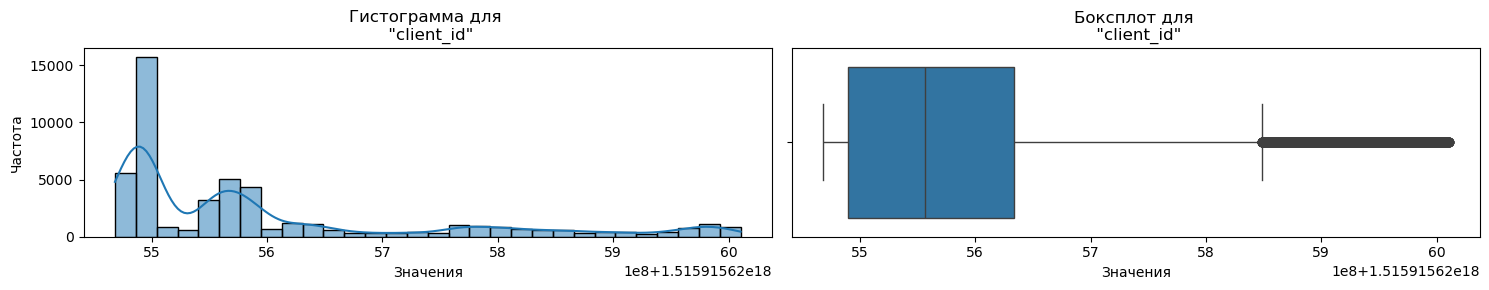

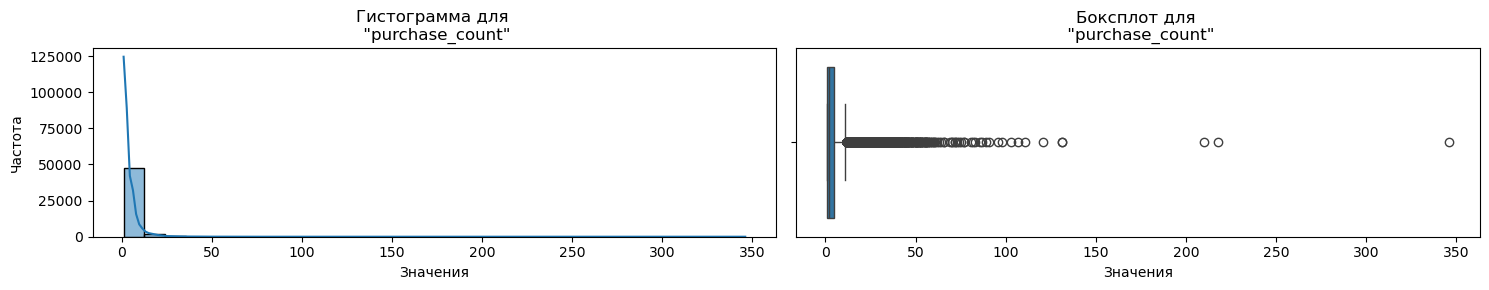

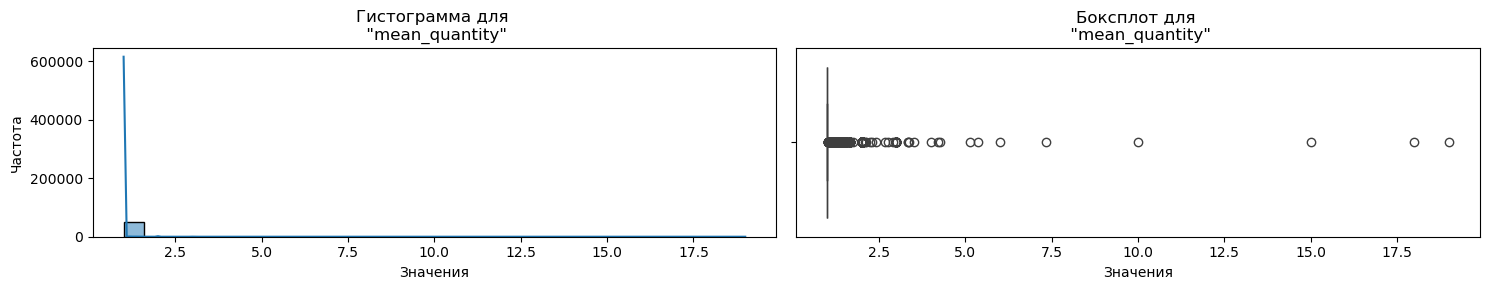

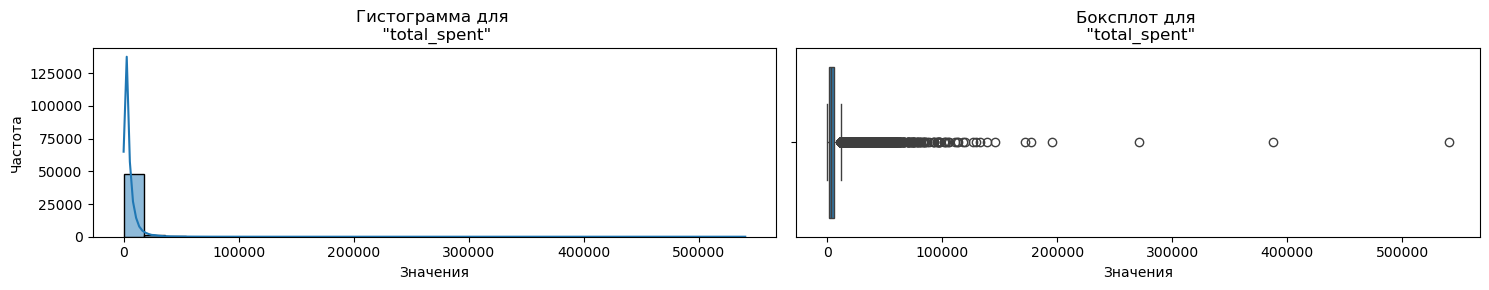

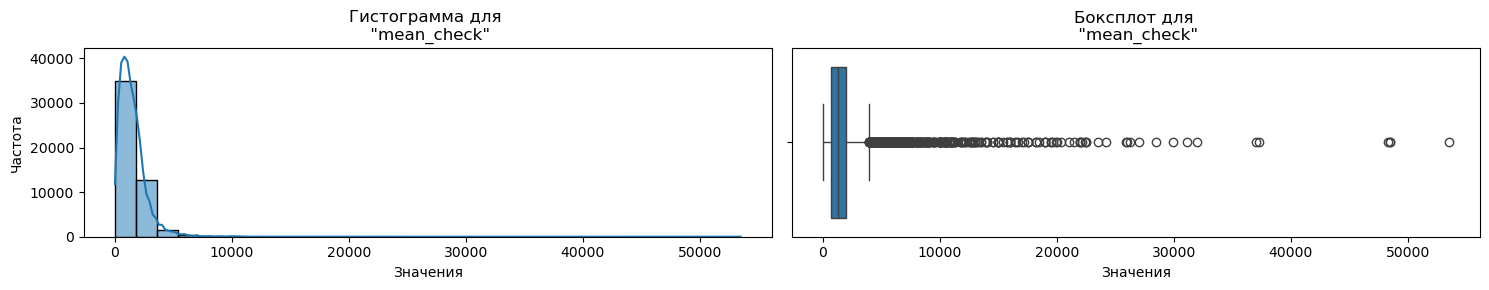

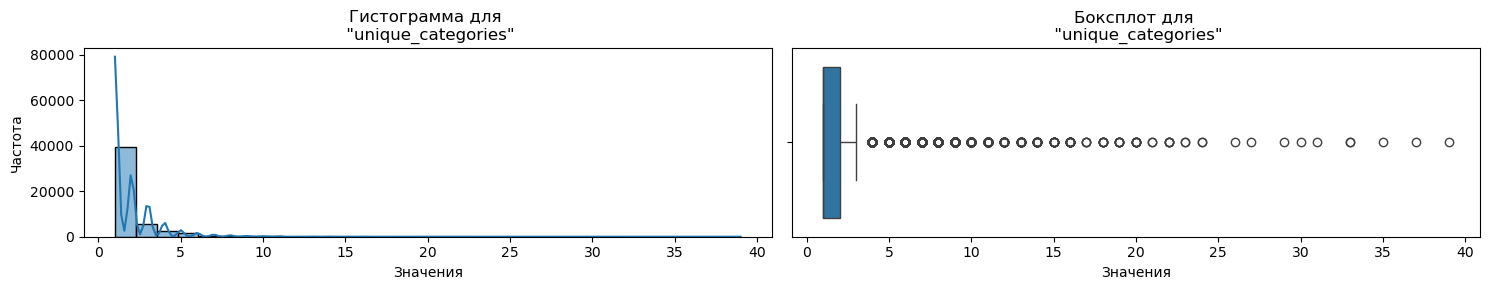

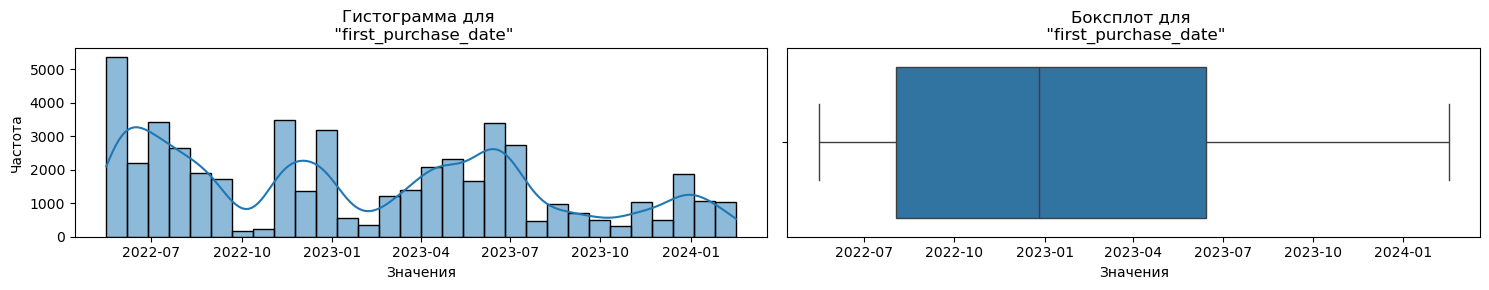

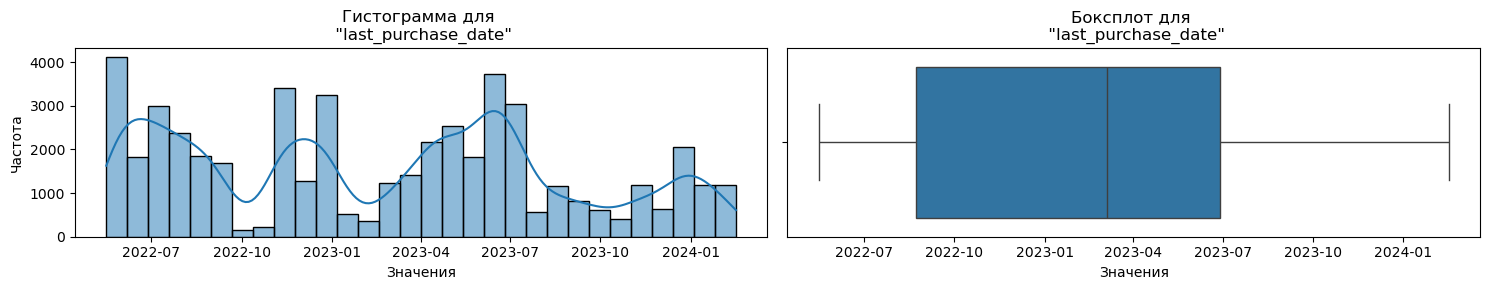

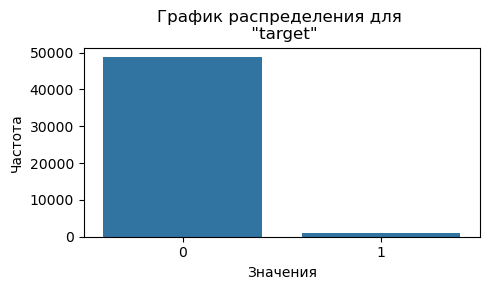

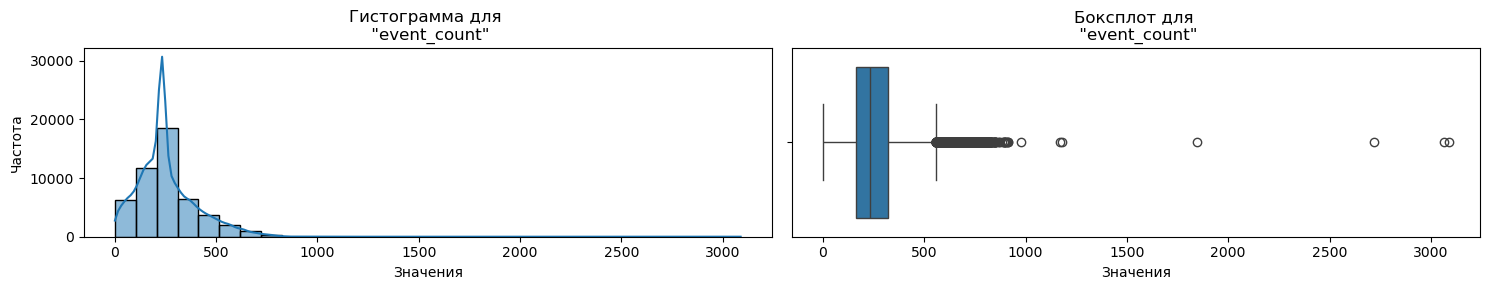

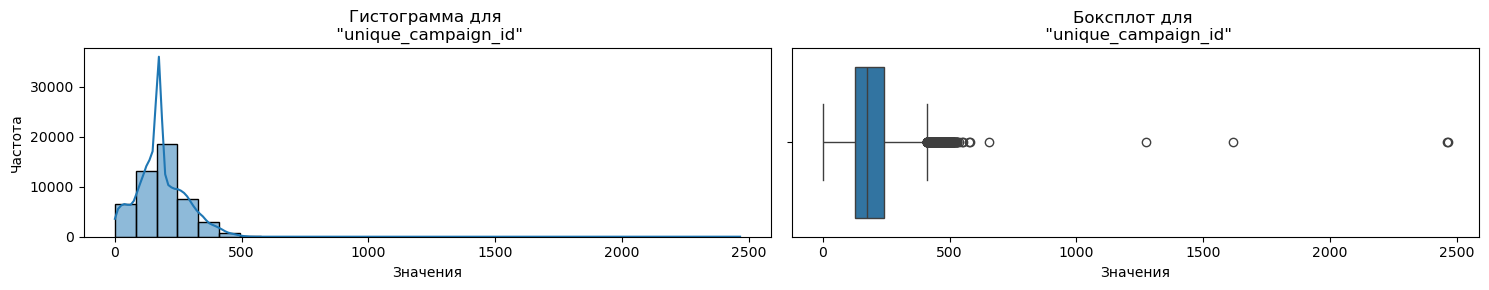

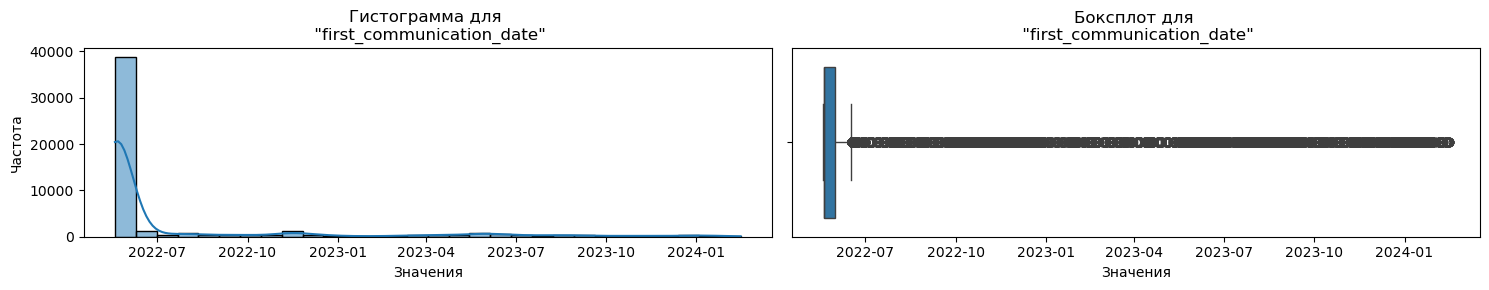

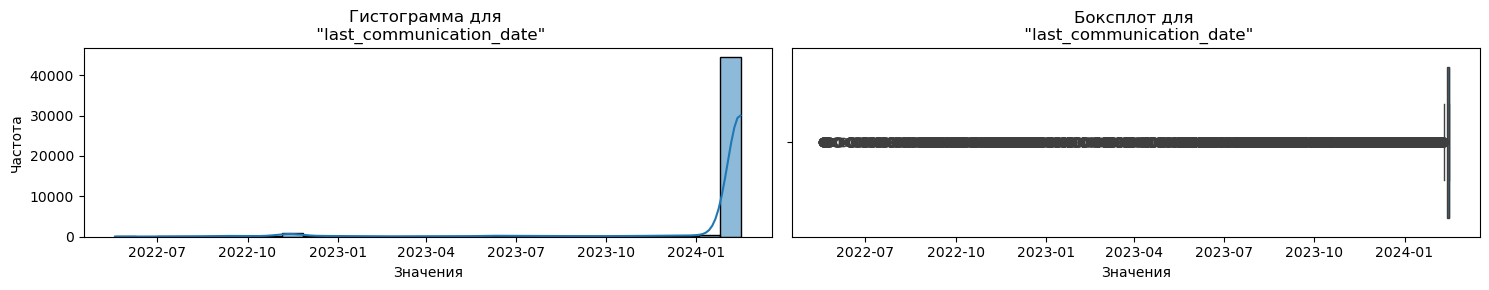

In [27]:
# Построение графиков
for name in df_fin: plot_graph(df_fin, name)

In [28]:
# Статистика по числовым столбцам
df_fin.describe()

,client_id,purchase_count,mean_quantity,total_spent,mean_check,unique_categories,first_purchase_date,last_purchase_date,target,event_count,unique_campaign_id,first_communication_date,last_communication_date
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849,49849
mean,1.515916e+18,4.056410,1.009452,4865.584264,1493.522136,1.880339,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,0.019278,255.696363,184.345624,2022-07-18 09:28:54.317639424,2024-01-13 12:57:59.467993088
min,1.515916e+18,1.000000,1.000000,1.000000,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,0.000000,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00
25%,1.515916e+18,1.000000,1.000000,1499.000000,699.000000,1.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,0.000000,163.000000,126.000000,2022-05-20 00:00:00,2024-02-13 00:00:00
50%,1.515916e+18,2.000000,1.000000,2969.000000,1249.000000,1.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,0.000000,233.000000,174.000000,2022-05-20 00:00:00,2024-02-15 00:00:00
75%,1.515916e+18,5.000000,1.000000,5698.000000,1999.000000,2.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,0.000000,321.000000,240.000000,2022-05-31 00:00:00,2024-02-15 00:00:00
max,1.515916e+18,346.000000,19.000000,540408.000000,53499.000000,39.000000,2024-02-16 00:00:00,2024-02-16 00:00:00,1.000000,3088.000000,2465.000000,2024-02-15 00:00:00,2024-02-15 00:00:00
std,1.487947e+08,5.521669,0.166519,7351.467229,1399.277858,1.613424,NaN,NaN,0.137503,146.176093,95.110310,NaN,NaN


В выборке почти 50 тысяч клиентов. Среднее количество покупок на клиента — около 4, при этом максимальное значение достигает 346, что указывает на наличие активных покупателей с большим числом транзакций. Средний чек клиента — около 1500, но максимальный чек достигает 53 499, а максимальная сумма всех покупок — более 540 тысяч, что говорит о наличии как мелких, так и крупных покупателей. Даты первой и последней покупки варьируются от мая 2022 до февраля 2024 года, что даёт достаточно широкий временной интервал для анализа покупательского поведения. Среднее количество взаимодействий с рассылками — около 219 на клиента, что говорит о высокой активности в коммуникациях.

Доля клиентов, совершивших покупку в целевом периоде (90 дней), около 1.9% (mean target = 0.019), что указывает на сильный дисбаланс классов.
Максимальное количество уникальных кампаний, в которых участвовал клиент — 2465, что говорит о разнообразии маркетинговых воздействий.
Среднее количество событий взаимодействия с рассылками — около 219.
Необходимо проработать признаки, учитывая высокую вариативность и разброс данных.

In [29]:
# Список признаков, где можно применить отсечение сна 90м перцентиле и 1м
to_cap = ['purchase_count', 'total_spent',
          'mean_check', 'unique_categories', 'event_count', 'unique_campaign_id']

for feature in to_cap:
    lower = df_fin[feature].quantile(0.1)
    upper = df_fin[feature].quantile(0.90)
    df_fin[feature] = df_fin[feature].clip(lower=lower, upper=upper)
    print(f'{feature}: cap [{lower:.2f}, {upper:.2f}]')

purchase_count: cap [1.00, 8.00]
total_spent: cap [799.00, 10387.20]
mean_check: cap [349.00, 2799.00]
unique_categories: cap [1.00, 3.00]
event_count: cap [86.00, 460.20]
unique_campaign_id: cap [64.00, 314.00]


In [30]:
df_fin.describe()

,client_id,purchase_count,mean_quantity,total_spent,mean_check,unique_categories,first_purchase_date,last_purchase_date,target,event_count,unique_campaign_id,first_communication_date,last_communication_date
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849,49849
mean,1.515916e+18,3.314690,1.009452,4010.566451,1367.440516,1.628558,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,0.019278,248.870088,181.922085,2022-07-18 09:28:54.317639424,2024-01-13 12:57:59.467993088
min,1.515916e+18,1.000000,1.000000,799.000000,349.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,0.000000,86.000000,64.000000,2022-05-19 00:00:00,2022-05-19 00:00:00
25%,1.515916e+18,1.000000,1.000000,1499.000000,699.000000,1.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,0.000000,163.000000,126.000000,2022-05-20 00:00:00,2024-02-13 00:00:00
50%,1.515916e+18,2.000000,1.000000,2969.000000,1249.000000,1.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,0.000000,233.000000,174.000000,2022-05-20 00:00:00,2024-02-15 00:00:00
75%,1.515916e+18,5.000000,1.000000,5698.000000,1999.000000,2.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,0.000000,321.000000,240.000000,2022-05-31 00:00:00,2024-02-15 00:00:00
max,1.515916e+18,8.000000,19.000000,10387.200000,2799.000000,3.000000,2024-02-16 00:00:00,2024-02-16 00:00:00,1.000000,460.200000,314.000000,2024-02-15 00:00:00,2024-02-15 00:00:00
std,1.487947e+08,2.382542,0.166519,3082.232388,789.945113,0.810608,NaN,NaN,0.137503,114.208119,76.840100,NaN,NaN


Значения purchase_count ограничены сверху на уровне 8, снизились с 4 до 3.3, что уменьшает влияние крайне активных покупателей с большим числом покупок и товаров.
Средний total_spent уменьшился с 4865 до 4010, а mean_check — с 1493 до 1367. total_spent ограничен сверху примерно 10 387, а mean_check — около 2 799, что снижает влияние крупных выбросов с очень большими суммами покупок.
unique_categories теперь варьируется от 1 до 3, что отражает ограничение разнообразия категорий для большинства клиентов.
event_count и unique_campaign_id также ограничены сверху (460 и 314), что уменьшает влияние очень активных клиентов в рассылках.
Стандартные отклонения уменьшились, что говорит о снижении разброса данных после капирования.
Максимальные значения теперь соответствуют 90% перцентилю, что улучшает устойчивость модели к выбросам.

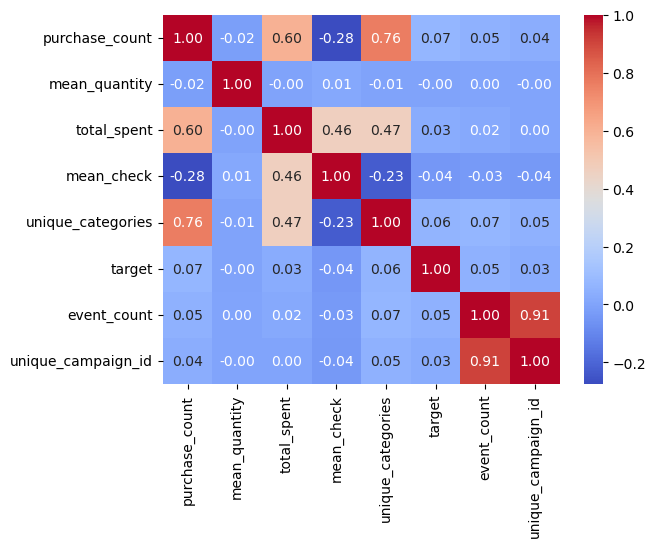

In [31]:
# Только числовые колонки
numeric_cols = df_fin.select_dtypes(include=['number']).columns.drop('client_id')
numeric_df = df_fin[numeric_cols]

# Корреляционная матрица
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [32]:
# Преобразование numpy-массив
X1 = numeric_df.values

# VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(X1, i) for i in range(X1.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

              feature        VIF
7  unique_campaign_id  36.486677
6         event_count  32.445543
0      purchase_count  14.160256
1       mean_quantity  13.586673
2         total_spent  11.757504
4   unique_categories  11.588057
3          mean_check  10.974254
5              target   1.029306


Высокие VIF и корреляция у unique_campaign_id и event_count, что указывает на мультиколлинеарность, они отражают активность в рассылках и маркетинговых кампаниях, что может быть взаимосвязано.
Остальные числовые признаки (mean_quantity, total_spent, mean_check, unique_categories) имеют VIF в диапазоне от 11 до 14, что тоже достаточно высоко.
Целевой признак target имеет VIF около 1, что нормально (признак не коррелирует с признаками, так как это целевая переменная).

Высокая мультиколлинеарность может привести к нестабильности оценок коэффициентов модели, ухудшению интерпретируемости и снижению качества обобщения.
В проекте стоит задача классификации (бинарный таргет), поэтому лучше использовать LogisticRegressionCV. Регуляризация зануляет коэффициенты менее важных признаков, что помогает бороться с мультиколлинеарностью и упрощает модель.

In [33]:
# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение логистической регрессии с L1-регуляризацией
logreg = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train_scaled, y_train)

# Коэффициенты признаков
coef = pd.Series(logreg.coef_[0], index=X.columns)
print("Коэффициенты признаков:")
print(coef)

# Признаки с ненулевыми коэффициентами
selected_features = coef[coef != 0].index.tolist()
print("Выбранные признаки:", selected_features)

Коэффициенты признаков:
purchase_count        0.569412
mean_quantity        -0.048703
total_spent           0.287619
mean_check           -0.325155
unique_categories    -0.349434
event_count           0.960455
unique_campaign_id   -0.632472
dtype: float64
Выбранные признаки: ['purchase_count', 'mean_quantity', 'total_spent', 'mean_check', 'unique_categories', 'event_count', 'unique_campaign_id']


purchase_count, total_spent, event_count — чем больше, тем выше вероятность покупки. Активные покупатели и активные в рассылках с большей вероятностью сделают покупку.
mean_quantity, mean_check, unique_categories, unique_campaign_id — с ростом этих признаков вероятность покупки падает. Например, большое среднее количество товаров на покупку (mean_quantity) или большой средний чек (mean_check) могут указывать на редких, но крупных покупателей.

              feature        VIF
0      purchase_count   7.975308
1       mean_quantity   7.614367
2         total_spent   4.194053
3          mean_check   3.560738
4   unique_categories   7.903991
5         event_count  23.171186
6  unique_campaign_id  27.503486


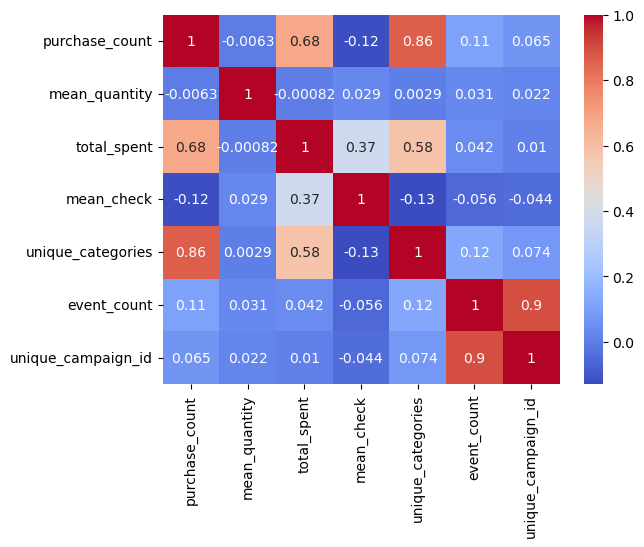

In [34]:
# Только выбранные признаки из X_train
X_selected = pd.DataFrame(X_train, columns=X_train.columns)[selected_features]

# VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_selected.values, i) for i in range(len(selected_features))]

print(vif_data)

corr = X_selected.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

После регуляризации в таблице сохраняется мультиколлинеарность между event_count и unique_campaign_id. unique_campaign_id нужно удалить, так как связь с целевой переменной у этого признака ниже.

Коэффициенты признаков после удаления unique_campaign_id:
purchase_count       0.550883
mean_quantity       -0.032035
total_spent          0.313220
mean_check          -0.333586
unique_categories   -0.325184
event_count          0.373563
dtype: float64
             feature       VIF
0     purchase_count  7.959313
1      mean_quantity  6.776322
2        total_spent  4.177731
3         mean_check  3.553351
4  unique_categories  7.878664
5        event_count  4.370837


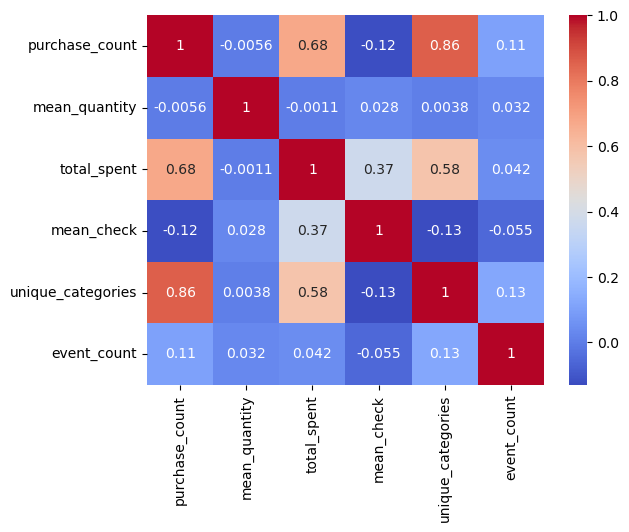

In [35]:
# Удаляем unique_campaign_id из признаков
X_reduced = X.drop(columns=['unique_campaign_id'])

# Делим на train и test с учетом новых признаков
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.25, stratify=y, random_state=42
)

# Балансируем классы
X_train, y_train = smote.fit_resample(X_train, y_train)

# Масштабируем данные
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем логистическую регрессию с L1-регуляризацией
logreg.fit(X_train_scaled, y_train)

# Анализируем коэффициенты
coef = pd.Series(logreg.coef_[0], index=X_reduced.columns)
print("Коэффициенты признаков после удаления unique_campaign_id:")
print(coef)

# Проверяем мультиколлинеарность с помощью VIF
X_selected = pd.DataFrame(X_train, columns=X_reduced.columns)
vif_data = pd.DataFrame()
vif_data['feature'] = X_reduced.columns
vif_data['VIF'] = [variance_inflation_factor(X_selected.values, i) for i in range(len(X_reduced.columns))]
print(vif_data)

# Корреляционная матрица
corr = X_selected.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Корреляция достаточно высокая между unique_categories и purchase_count, но VIF при этом невысокие.

В выборке около 50 тысяч клиентов с широким разбросом по активности и объему покупок: от мелких до очень крупных покупателей, что отражается в большом диапазоне значений purchase_count, total_spent и mean_check. Анализ временного интервала с мая 2022 по февраль 2024 даёт достаточную базу для изучения покупательского поведения. Высокая активность взаимодействий с рассылками и маркетинговыми кампаниями подтверждается большим количеством событий и уникальных кампаний. Применённое капирование признаков на уровне примерно 90% перцентиля позволило снизить влияние экстремальных выбросов, уменьшить разброс и повысить устойчивость модели, при этом сохранив информативность данных.

Диагностика мультиколлинеарности выявила высокие значения VIF у большинства признаков, хотя явных сильных парных корреляций не наблюдается. Это говорит о наличии сложных линейных зависимостей между признаками, особенно между показателями активности в рассылках (unique_campaign_id, event_count) и основными покупательскими метриками. Высокая мультиколлинеарность может негативно влиять на стабильность и интерпретируемость модели.
Выбранные признаки имеют логичные направления влияния: активные покупатели и активные в рассылках (purchase_count, total_spent, event_count) с большей вероятностью совершат покупку, тогда как признаки, характеризующие крупные, но редкие покупки (mean_quantity, mean_check, unique_categories), связаны с пониженной вероятностью покупки в целевой период.
Если при построении модели сохраняется хорошая метрика качества (roc_auc) и стабильность, корреляцию и умеренные значения VIF можно считать приемлемыми, особенно учитывая отсутствие сильных парных корреляций.

## 1.4 Обучение моделей
<a id='str4'></a>

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Категориальных признаков нет — пустой список
cat_features = []

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# Предсказание и оценка
y_pred_proba = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC на валидации: {auc:.4f}')

# Важность признаков
importances = model.get_feature_importance(prettified=True)
print(importances)

0:	test: 0.5880522	best: 0.5880522 (0)	total: 157ms	remaining: 2m 36s
100:	test: 0.6847478	best: 0.6850395 (96)	total: 1.36s	remaining: 12.1s
200:	test: 0.6878283	best: 0.6887626 (178)	total: 2.65s	remaining: 10.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6887626469
bestIteration = 178

Shrink model to first 179 iterations.
ROC AUC на валидации: 0.6888
           Feature Id  Importances
0         event_count    25.898328
1          mean_check    19.654433
2  unique_campaign_id    18.528676
3         total_spent    17.083632
4      purchase_count    10.752787
5   unique_categories     4.606003
6       mean_quantity     3.476141


Результат обучения показал, что модель достигла оптимума на 179-й итерации, после чего сработал детектор переобучения. ROC AUC около 0.689 — это неплохо, но есть возможность роста. Для улучшения качества можно попробовать провести тщательную настройку гиперпараметров, или использовать кросс-валидацию для более стабильной оценки.

In [37]:
X_reduced = X.drop(columns=['unique_campaign_id'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X_reduced, y, test_size=0.25, stratify=y, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

y_pred_proba = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC без unique_campaign_id: {auc:.4f}')

print(model.get_feature_importance(prettified=True))

0:	test: 0.6012502	best: 0.6012502 (0)	total: 14.3ms	remaining: 14.3s
100:	test: 0.6793816	best: 0.6794489 (97)	total: 1.46s	remaining: 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6794489214
bestIteration = 97

Shrink model to first 98 iterations.
ROC AUC без unique_campaign_id: 0.6794
          Feature Id  Importances
0        event_count    31.104143
1         mean_check    24.506127
2        total_spent    20.697602
3     purchase_count    10.704969
4  unique_categories     7.247539
5      mean_quantity     5.739620


Модель остановилась на 98-й итерации из-за детектора переобучения, ранняя остановка сработала.
ROC AUC на валидации — около 0.679, что примерно соответствует предыдущим результатам без unique_campaign_id.
Важность признаков показывает, что event_count, mean_check и total_spent — самые значимые факторы.
Отсутствие unique_campaign_id не привело к резкому падению качества, но небольшое снижение по сравнению с моделью с этим признаком было.

In [38]:
model = CatBoostClassifier(
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=False
)

param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [200, 500, 1000]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=2
)

random_search.fit(X, y, cat_features=cat_features)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC AUC: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END depth=4, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=   5.5s
[CV] END depth=4, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=   5.7s
[CV] END depth=4, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=   5.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   2.2s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   2.3s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   2.2s
[CV] END depth=6, iterations=500, l2_leaf_reg=7, learning_rate=0.03; total time=   6.9s
[CV] END depth=6, iterations=500, l2_leaf_reg=7, learning_rate=0.03; total time=   6.6s
[CV] END depth=6, iterations=500, l2_leaf_reg=7, learning_rate=0.03; total time=   6.1s
[CV] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.03; total time=  12.3s
[CV] END depth=6, iterations=1000, l2_leaf_reg=5, learning

Гиперпараметры с меньшей глубиной и небольшим числом итераций показывают лучший результат.
Это указывает на то, что модель с меньшей сложностью лучше обобщается на данных, и переобучение при больших глубинах/итерациях возможно.
ROC AUC около 0.6785, сопоставим с результатом без unique_campaign_id (~0.6794), что подтверждает стабильность результата.
Низкое число итераций (200) и небольшая глубина (4) позволяют значительно экономить время обучения, что удобно для дальнейших экспериментов.

In [39]:
# Параметры из RandomizedSearchCV
best_params = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'iterations': 200,
    'depth': 4,
    'random_seed': 42,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 100
}

# Создаем модель с лучшими параметрами
model = CatBoostClassifier(**best_params)

# Обучаем на всей обучающей выборке
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),  # если есть валидационная выборка для ранней остановки
    use_best_model=True
)

# Предсказания вероятностей на тесте
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оценка качества
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC на тестовой выборке: {roc_auc:.4f}")

0:	test: 0.5670401	best: 0.5670401 (0)	total: 14.7ms	remaining: 2.92s
100:	test: 0.6783905	best: 0.6783905 (100)	total: 1.31s	remaining: 1.29s
199:	test: 0.6806178	best: 0.6806802 (195)	total: 2.56s	remaining: 0us

bestTest = 0.6806802067
bestIteration = 195

Shrink model to first 196 iterations.
ROC AUC на тестовой выборке: 0.6807


Финальный CatBoostClassifier с подобранными параметрами показал ROC AUC около 0.6807 на тестовой выборке — это немного лучше, чем результат кросс-валидации (~0.6785). Это значит, что модель хорошо обобщается и подобранные гиперпараметры подходят для данной задачи. Также ранняя остановка сработала на 196 итерации, чуть раньше заданного максимума 200, что помогает избежать переобучения.

## 1.5 Общий вывод
<a id='str5'></a>

Общий вывод по проекту "Маркетинг".

Проект по предсказанию вероятности покупки клиентов интернет-магазина в течение 90 дней выполнен комплексно и последовательно, что позволило получить рабочую модель с приемлемым качеством.

Основные действия:
- Проведен тщательный анализ и предобработка данных из нескольких источников — покупок, рассылок и целевого признака. Особое внимание уделено обработке вложенных и изменяющихся категорий товаров, а также агрегации данных по клиентам, что позволило создать информативный набор признаков.
- Устранены дубликаты и пропуски, выполнено капирование признаков для снижения влияния выбросов. Это повысило устойчивость модели и качество признаков.
- Учтена сильная дисбалансированность целевой переменной (около 2% положительных примеров) с помощью оверсемплинга, что улучшило обучение и стабильность модели.
- Проведен анализ мультиколлинеарности, выявлены сложные взаимосвязи между признаками, но при этом сохранена интерпретируемость и логичность влияния ключевых факторов.
- Обучена модель CatBoostClassifier с подбором гиперпараметров и применением ранней остановки, что позволило избежать переобучения и достичь стабильного результата.
- Итоговое качество модели по метрике ROC AUC — около 0.68, что является хорошим показателем для задач с таким уровнем сложности и дисбалансом данных.
- Важнейшими признаками оказались показатели активности в рассылках, средний чек и суммарные затраты, что подтверждает значимость маркетинговых коммуникаций и покупательской активности для предсказания будущих покупок.

Рекомендации и перспективы улучшения:
- Можно попробовать более сложные методы балансировки классов и расширение набора признаков, например, более глубокий анализ временных рядов покупок и рассылок.
- Исследовать дополнительные алгоритмы и ансамблирование моделей для повышения качества.
- Внедрить более продвинутую обработку категорий товаров с учетом изменений в структуре и вложенности.
- Провести более глубокую кросс-валидацию и тестирование на разных сегментах клиентов для повышения стабильности и обобщаемости модели.

Проект успешно решает поставленную задачу — предсказание вероятности покупки в ближайшие 90 дней с использованием комплексного анализа данных о покупках и маркетинговых рассылках. Полученная модель имеет хорошую интерпретируемость и стабильность, что позволяет использовать её для оптимизации маркетинговых кампаний и повышения эффективности работы интернет-магазина.